# Testing
### Hundenamen aus dem Hundebeständen der Stadt Zürich seit 2015

https://data.stadt-zuerich.ch/dataset/sid_stapo_hundenamen_od1002

https://data.integ.stadt-zuerich.ch/dataset/int_dwh_sid_stapo_hundenamen_od1002

**Beschreibung**

In diesem Datensatz finden Sie die Namen aller Hunde aus dem aktuellen Bestand des Hunderegisters der Stadt Zürich. Zudem ist zu jedem Hund noch das Geburtsjahr und das Geschlecht angegeben. Das Hunderegister wird von der Abteilung Hundekontrolle der Stadtpolizei Zürich geführt.

Datum: 26.09.2022



### Importiere die notwendigen Packages

In [83]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly leafmap

In [84]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns
import leafmap

import requests
import io

import plotly.express as px


Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [85]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [86]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")

date_day_a_week_ago = (datetime.datetime.now() - datetime.timedelta(days=7)).date()
day_a_week_ago = date_day_a_week_ago.strftime('%Y-%m-%d')


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [87]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 9 datenstand:  7 time.struct_time(tm_year=2022, tm_mon=9, tm_mday=29, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=3, tm_yday=272, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [88]:
epoch = datetime.datetime(1960, 1, 1)

### Setze einige Pfadvariabeln

- Der Packagename ist eigentlich der **Verzeichnisname** unter dem die Daten und Metadaten auf der Dropzone abgelegt werden.
- Definiert wird er bei SASA-Prozessen auf dem **Produkte-Sharepoint ([Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/PersonalViews.aspx?PageView=Personal&ShowWebPart={6087A3E7-8AC8-40BA-8278-DECFACE124FF}))**.
- Der Packagename wird auf CKAN teil der URL, daher ist die exakte Schreibweise wichtig.

Beachte: im Packagename müssen alle Buchstaben **klein** geschrieben werden. Dies weil CKAN aus grossen kleine Buchstaben macht.

**BITTE HIER ANPASSEN**

In [89]:
package_name = "sid_stapo_hundenamen_od1002"

In [90]:
dataset_name = "KUL100OD1002.csv"

**Statische Pfade in DWH-Dropzones**

In [91]:
dropzone_path_integ = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH"

In [92]:
dropzone_path_prod = r"\\szh\ssz\applikationen\OGD_Dropzone\DWH"

**Statische Pfade CKAN-URLs**

In [93]:
ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/int_dwh_"

In [94]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [95]:
from IPython.display import Markdown as md

In [96]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name))

 **1. Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/int_dwh_sid_stapo_hundenamen_od1002 

In [97]:
md(" **2. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name))

 **2. Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/sid_stapo_hundenamen_od1002 

### Importiere einen Datensatz 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?

In [98]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "prod"; #prod vs something else
data_source = "web"; #dropzone vs something else
print(status+" - "+ data_source)

prod - web


In [99]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            fp = dropzone_path_prod+"\\"+ package_name +"\\"+dataset_name
            print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_prod_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        fp = dropzone_path_integ+"\\"+ package_name +"\\"+dataset_name
        print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_integ_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)


fp lautet:https://data.stadt-zuerich.ch/dataset/sid_stapo_hundenamen_od1002/download/KUL100OD1002.csv


Beachte, wie das SAS Datum (ohne Format) in ein UNIX Datum umgerechnet und als Datumsformat dargestellt wird! Siehe dazu `https://stackoverflow.com/questions/26923564/convert-sas-numeric-to-python-datetime`

In [100]:
# Read the data

if data_source == "dropzone":
    data2betested = pd.read_csv(
        fp
        , sep=','
        ,parse_dates=['StichtagDatJahr']
        ,low_memory=False
    )
    print("dropzone")
else:
    r = requests.get(fp, verify=False)  
    r.encoding = 'utf-8'
    data2betested = pd.read_csv(
        io.StringIO(r.text)
        ,parse_dates=['StichtagDatJahr','GebDatHundJahr']
        # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
        #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
        , sep=','        
        ,low_memory=False)
    print("web")

data2betested.dtypes

web


StichtagDatJahr    datetime64[ns]
HundenameText              object
GebDatHundJahr             object
SexHundCd                   int64
SexHundLang                object
SexHundSort                 int64
AnzHunde                    int64
dtype: object

In [101]:
data2betested = (
    data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        StichtagDatJahr_str = lambda x: x.StichtagDatJahr.astype(str),
        #GebDatHundJahr_dat = lambda x: pd.to_datetime(data2betested[['GebDatHundJahr']].query('GebDatHundJahr !="9999"')).strftime("%Y"),
        FirstLetter = lambda x: x.HundenameText.astype(str).str[0],
        SecondLetter = lambda x: x.HundenameText.astype(str).str[1],        
        FirstTwoLetters = lambda x: x.HundenameText.str.slice(stop=2), 
        
    )
    .sort_values('StichtagDatJahr', ascending=False)
    )
data2betested.dtypes

StichtagDatJahr        datetime64[ns]
HundenameText                  object
GebDatHundJahr                 object
SexHundCd                       int64
SexHundLang                    object
SexHundSort                     int64
AnzHunde                        int64
StichtagDatJahr_str            object
FirstLetter                    object
SecondLetter                   object
FirstTwoLetters                object
dtype: object

In [102]:
#data2betested

Berechne weitere Attribute falls notwendig

### Einfache Datentests

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [103]:
#data2betested.head(6)

In [104]:
data2betested.dtypes

StichtagDatJahr        datetime64[ns]
HundenameText                  object
GebDatHundJahr                 object
SexHundCd                       int64
SexHundLang                    object
SexHundSort                     int64
AnzHunde                        int64
StichtagDatJahr_str            object
FirstLetter                    object
SecondLetter                   object
FirstTwoLetters                object
dtype: object

In [105]:
data2betested.shape

(55353, 11)

Beschreibe einzelne Attribute

In [106]:
data2betested.describe()

SexHundCd  SexHundSort  AnzHunde
count      55353        55353     55353
mean           1            1         1
std            1            1         0
min            1            1         1
25%            1            1         1
50%            1            1         1
75%            2            2         1
max            2            2        17

Wie viele Nullwerte gibt es im Datensatz?

In [107]:
data2betested.isnull().sum()

StichtagDatJahr         0
HundenameText           0
GebDatHundJahr          0
SexHundCd               0
SexHundLang             0
SexHundSort             0
AnzHunde                0
StichtagDatJahr_str     0
FirstLetter             0
SecondLetter           25
FirstTwoLetters         0
dtype: int64

Welches sind die Angaben ohne Werte bei AnzBestWir?

In [108]:
data2betested[np.isnan(data2betested.AnzHunde)]

Empty DataFrame
Columns: [StichtagDatJahr, HundenameText, GebDatHundJahr, SexHundCd, SexHundLang, SexHundSort, AnzHunde, StichtagDatJahr_str, FirstLetter, SecondLetter, FirstTwoLetters]
Index: []

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [109]:
data2betested = data2betested.set_index("StichtagDatJahr")

In [110]:
data2betested.loc["2016"].head(1)

HundenameText GebDatHundJahr  SexHundCd SexHundLang  SexHundSort  \
StichtagDatJahr                                                                                  
2016-01-01       Genette Bleue de la Vallée           2010          2    weiblich            2   

                 AnzHunde StichtagDatJahr_str FirstLetter SecondLetter FirstTwoLetters  
StichtagDatJahr                                                                         
2016-01-01              1          2016-01-01           G            e              Ge

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [35]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [111]:
data2betested.columns

Index(['HundenameText', 'GebDatHundJahr', 'SexHundCd', 'SexHundLang', 'SexHundSort', 'AnzHunde',
       'StichtagDatJahr_str', 'FirstLetter', 'SecondLetter', 'FirstTwoLetters'],
      dtype='object')

### Visualisierungen nach Zeitausschnitten

#### Entwicklung Hundenamen nach Erstbuchstaben

In [112]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.reset_index()\
    .groupby(['StichtagDatJahr','SexHundLang','FirstLetter','FirstTwoLetters']) \
    .agg(sum_AnzHunde=('AnzHunde', 'sum')) \
    .sort_values(['StichtagDatJahr','sum_AnzHunde'],ascending=[False,False], inplace=False) 

myAgg.reset_index().head(6)

StichtagDatJahr SexHundLang FirstLetter FirstTwoLetters  sum_AnzHunde
0      2022-01-01    weiblich           L              Lu           216
1      2022-01-01    weiblich           M              Mi           168
2      2022-01-01    männlich           C              Ch           163
3      2022-01-01    weiblich           M              Ma           153
4      2022-01-01    weiblich           L              Li           140
5      2022-01-01    männlich           B              Ba           134

#### Entwicklung 

In [113]:
myTitle="Weibliche Hundenamen nach Anfangsbuchstaben"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['FirstLetter'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('SexHundLang != "männlich"'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_AnzHunde', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('FirstTwoLetters', legend=alt.Legend(title="Anfangsbuchstaben", orient="right"))  
    ,tooltip=['StichtagDatJahr','SexHundLang', 'FirstLetter','FirstTwoLetters','sum_AnzHunde']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

In [114]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.reset_index()\
    .groupby(['StichtagDatJahr','SexHundLang','FirstLetter']) \
    .agg(sum_AnzHunde=('AnzHunde', 'sum')) \
    .sort_values(['StichtagDatJahr','sum_AnzHunde'],ascending=[False,False], inplace=False) 

myAgg.reset_index().head(6)

StichtagDatJahr SexHundLang FirstLetter  sum_AnzHunde
0      2022-01-01    weiblich           L           615
1      2022-01-01    männlich           B           489
2      2022-01-01    weiblich           M           444
3      2022-01-01    männlich           M           370
4      2022-01-01    männlich           S           341
5      2022-01-01    weiblich           S           341

In [115]:
myTitle="Männliche Hundenamen nach Anfangsbuchstaben"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['FirstLetter'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('SexHundLang != "männlich"'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_AnzHunde', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('FirstLetter', legend=alt.Legend(title="Anfangsbuchstaben", orient="right"))  
    ,tooltip=['StichtagDatJahr','SexHundLang', 'FirstLetter','sum_AnzHunde']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

In [116]:
TopNames = data2betested\
    .groupby(['HundenameText']) \
    .agg(sum_AnzHunde=('AnzHunde', 'sum')) \
    .sort_values(['sum_AnzHunde'],ascending=[False]) 

TopNames[0:9]
#data2betested.reset_index().columns

sum_AnzHunde
HundenameText              
Luna                    745
Rocky                   294
Leo                     257
Lucky                   254
Bella                   238
Coco                    225
Lola                    214
Mia                     212
Max                     203

In [117]:
myAgg = data2betested\
    .groupby(['StichtagDatJahr','HundenameText']) \
    .agg(sum_AnzHunde=('AnzHunde', 'sum')) \
    .sort_values(['sum_AnzHunde'],ascending=[False]) 

myAgg.head(2)

sum_AnzHunde
StichtagDatJahr HundenameText              
2022-01-01      Luna                    115
2015-01-01      Luna                     95

In [118]:
myTitle="Ausgewählte Hundenamen"
myQuery="HundenameText =='Luna' or HundenameText =='Coco' or HundenameText =='Rocky' or HundenameText =='Leo' or HundenameText =='Bella'or HundenameText =='Loca'"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['HundenameText'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query(myQuery), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_AnzHunde', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('HundenameText', legend=alt.Legend(title="Hundename", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'HundenameText','sum_AnzHunde']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1.5), alt.value(4))
).interactive()

lines + points
#.query('Vorname == ["Marco", "Karina", "Flavia", "Sol", "Aymée", "Lou", "Alan"]'

alt.LayerChart(...)

#### Barcharts mit Seaborn

In [119]:
data2betested.columns

Index(['HundenameText', 'GebDatHundJahr', 'SexHundCd', 'SexHundLang', 'SexHundSort', 'AnzHunde',
       'StichtagDatJahr_str', 'FirstLetter', 'SecondLetter', 'FirstTwoLetters'],
      dtype='object')

In [120]:
myAgg2022 = data2betested.loc["2022"]\
    .groupby(['StichtagDatJahr_str','SexHundLang', 'HundenameText']) \
    .agg(sum_AnzHunde=('AnzHunde', 'sum')) \
    .sort_values('sum_AnzHunde', ascending=False) 

myAgg2022.reset_index().head(3)

StichtagDatJahr_str SexHundLang HundenameText  sum_AnzHunde
0          2022-01-01    weiblich          Luna           115
1          2022-01-01    weiblich         Bella            45
2          2022-01-01    weiblich          Nala            38

In [121]:
myAgg2021 = data2betested.loc["2021"]\
    .groupby(['StichtagDatJahr_str','SexHundLang', 'HundenameText']) \
    .agg(sum_AnzHunde=('AnzHunde', 'sum')) \
    .sort_values('sum_AnzHunde', ascending=False) 

myAgg2021.reset_index().head(3)

StichtagDatJahr_str SexHundLang HundenameText  sum_AnzHunde
0          2021-01-01    weiblich          Luna            92
1          2021-01-01    weiblich         Bella            37
2          2021-01-01    männlich         Rocky            34

In [122]:
myAgg2019to2022 = data2betested.loc["2019":"2022"]\
    .groupby(['StichtagDatJahr_str','SexHundLang', 'HundenameText']) \
    .agg(sum_AnzHunde=('AnzHunde', 'sum')) \
    .sort_values('sum_AnzHunde', ascending=False) 

myAgg2019to2022.reset_index().head(3)

StichtagDatJahr_str SexHundLang HundenameText  sum_AnzHunde
0          2022-01-01    weiblich          Luna           115
1          2021-01-01    weiblich          Luna            92
2          2019-01-01    weiblich          Luna            88

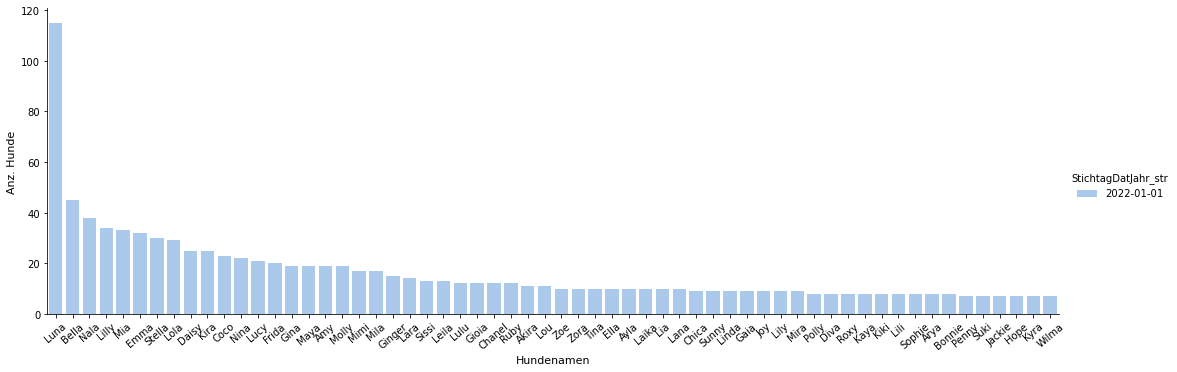

In [123]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="HundenameText"
            , y="sum_AnzHunde"
            , hue="StichtagDatJahr_str"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=3
            , order=None, legend_out=True
            ,data=myAgg2022.query('SexHundLang =="weiblich"').reset_index().head(60)
           )
myHist.set_xticklabels(rotation=40) 
myHist.set_xlabels('Hundenamen', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Hunde', fontsize=11)


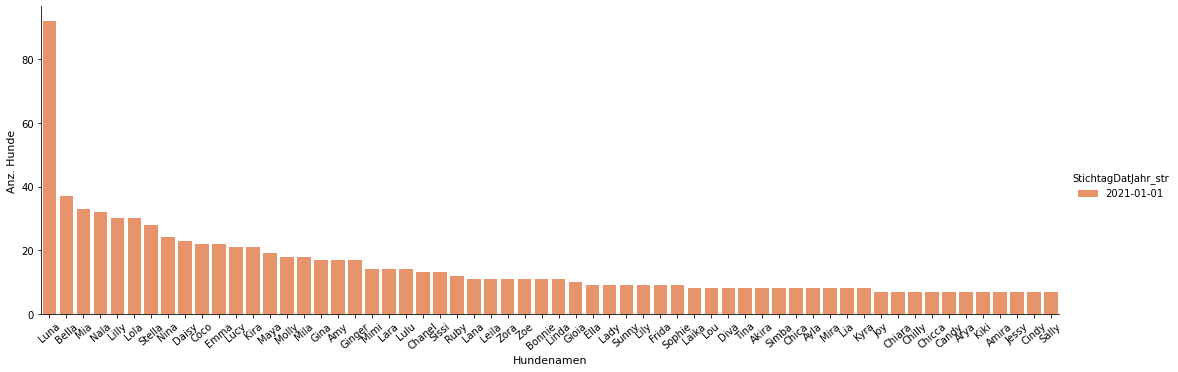

In [124]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="HundenameText"
            , y="sum_AnzHunde"
            , hue="StichtagDatJahr_str"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="OrRd" #, color="green"
            , height=5
            , aspect=3
            , order=None, legend_out=True
            ,data=myAgg2021.query('SexHundLang =="weiblich"').reset_index().head(60)
           )
myHist.set_xticklabels(rotation=40) 
myHist.set_xlabels('Hundenamen', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Hunde', fontsize=11)

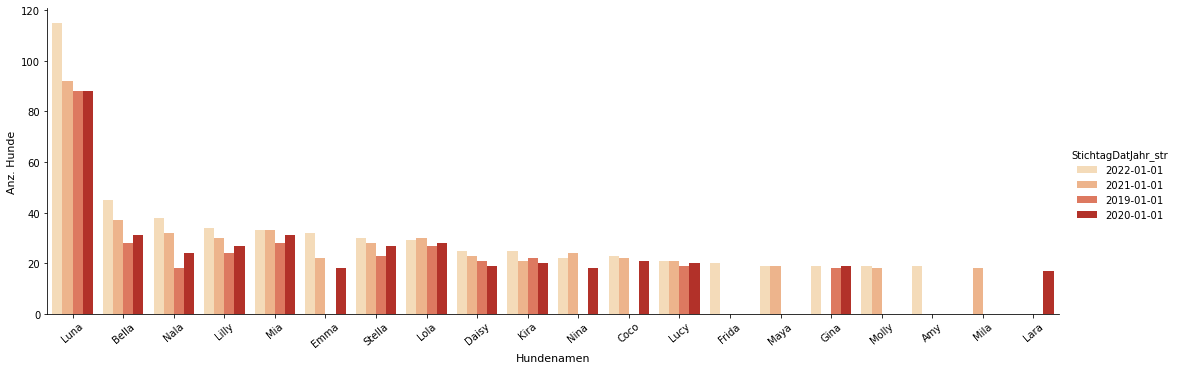

In [125]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="HundenameText"
            , y="sum_AnzHunde"
            , hue="StichtagDatJahr_str"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="OrRd" #, color="green"
            , height=5
            , aspect=3
            , order=None, legend_out=True
            ,data=myAgg2019to2022.query('SexHundLang =="weiblich"').reset_index().head(60)
           )
myHist.set_xticklabels(rotation=40) 
myHist.set_xlabels('Hundenamen', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Hunde', fontsize=11)


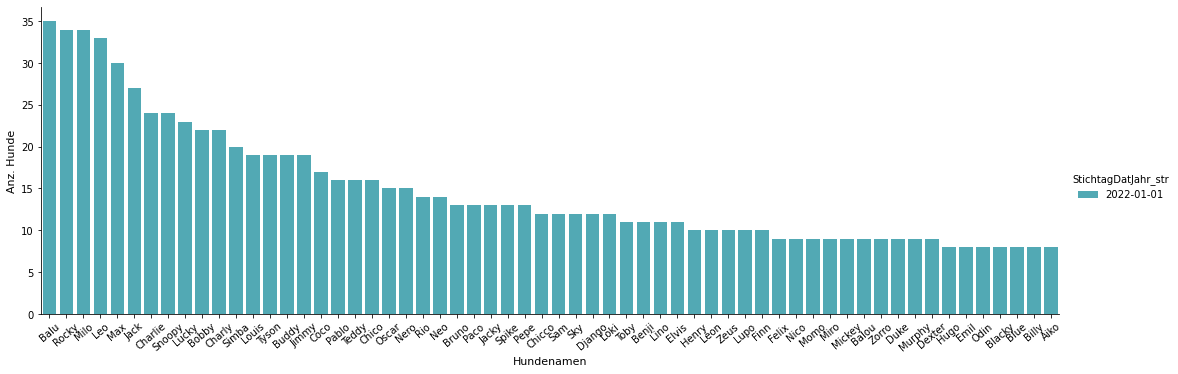

In [126]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="HundenameText"
            , y="sum_AnzHunde"
            , hue="StichtagDatJahr_str"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="YlGnBu_r" #, color="green"
            , height=5
            , aspect=3
            , order=None, legend_out=True
            ,data=myAgg2022.query('SexHundLang !="weiblich"').reset_index().head(60)
           )
myHist.set_xticklabels(rotation=40) 
myHist.set_xlabels('Hundenamen', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Hunde', fontsize=11)


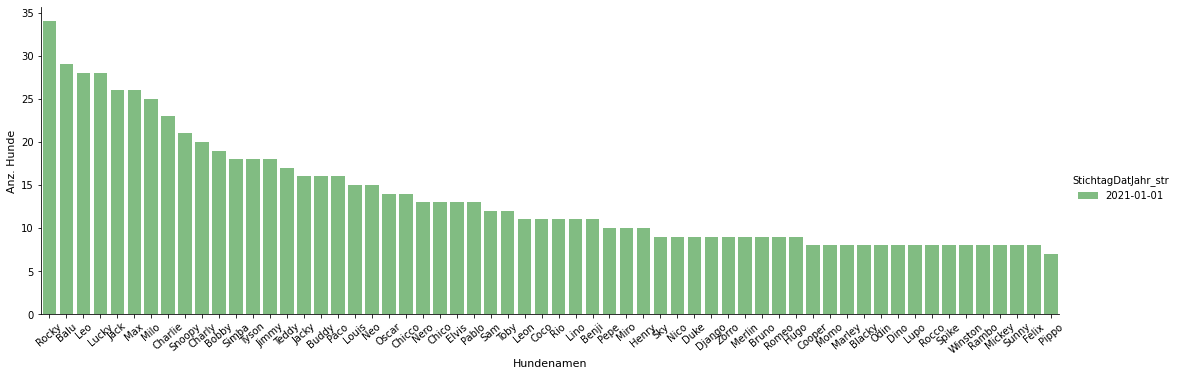

In [127]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="HundenameText"
            , y="sum_AnzHunde"
            , hue="StichtagDatJahr_str"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="YlGn" #, color="green"
            , height=5
            , aspect=3
            , order=None, legend_out=True
            ,data=myAgg2021.query('SexHundLang !="weiblich"').reset_index().head(60)
           )
myHist.set_xticklabels(rotation=40) 
myHist.set_xlabels('Hundenamen', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Hunde', fontsize=11)


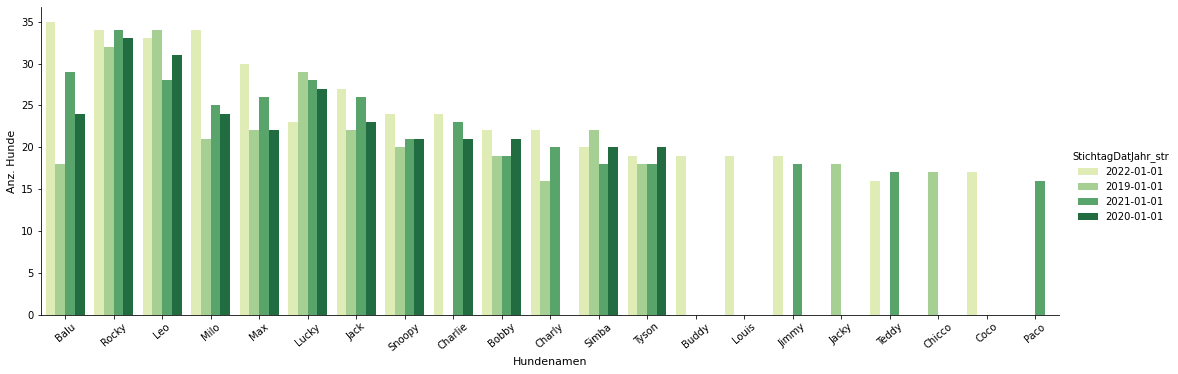

In [128]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="HundenameText"
            , y="sum_AnzHunde"
            , hue="StichtagDatJahr_str"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="YlGn" #, color="green"
            , height=5
            , aspect=3
            , order=None, legend_out=True
            ,data=myAgg2019to2022.query('SexHundLang !="weiblich"').reset_index().head(60)
           )
myHist.set_xticklabels(rotation=40) 
myHist.set_xlabels('Hundenamen', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Hunde', fontsize=11)

In [129]:
data2betested.columns


Index(['HundenameText', 'GebDatHundJahr', 'SexHundCd', 'SexHundLang', 'SexHundSort', 'AnzHunde',
       'StichtagDatJahr_str', 'FirstLetter', 'SecondLetter', 'FirstTwoLetters'],
      dtype='object')

In [130]:
myAggBar = data2betested.loc["2015":year_today]\
    .groupby(['HundenameText', 'SexHundLang', 'StichtagDatJahr_str', 'FirstLetter']) \
    .agg(sum_AnzHunde=('AnzHunde', 'sum')) \
    .sort_values('sum_AnzHunde', ascending=False) 

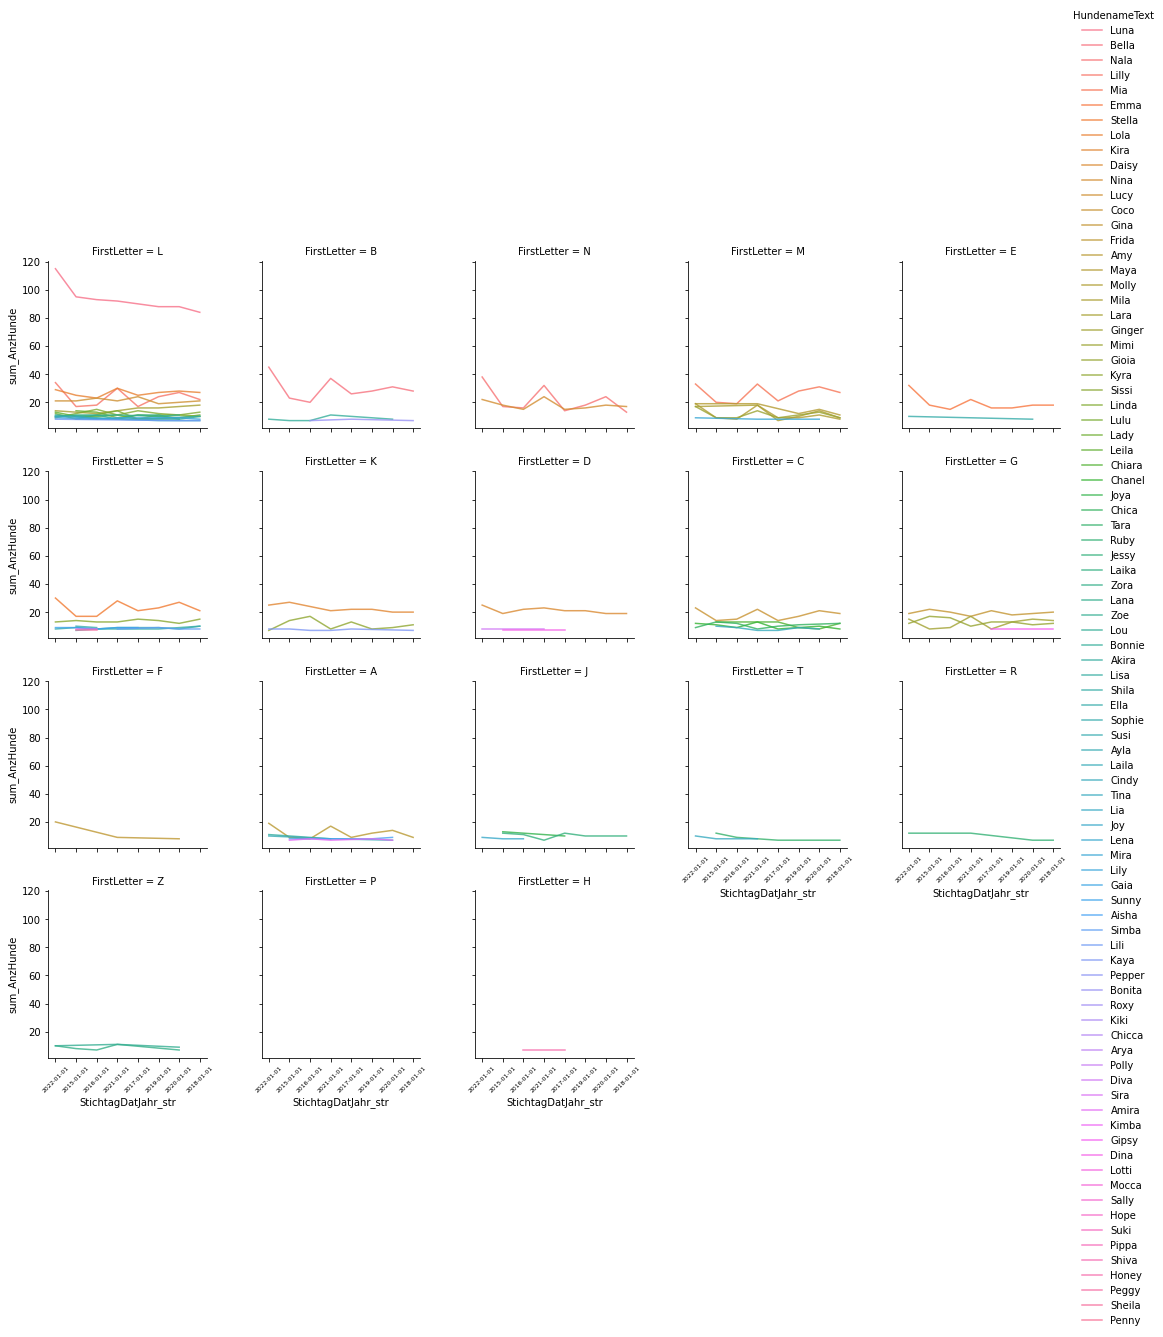

In [131]:
#g2 = sns.FacetGrid(myAggBar.query('FirstLetter==["A","B","C","D","E","F","G","H","I"]',inplace=False).reset_index().head(200), col="FirstLetter", hue="Vorname", col_wrap=5, height=3,)
g2 = sns.FacetGrid(myAggBar.query('SexHundLang == "weiblich"').reset_index().head(400), col="FirstLetter", hue="HundenameText", col_wrap=5, height=3,)
g2.map(sns.lineplot, "StichtagDatJahr_str","sum_AnzHunde",alpha=.8)

g2.set_xticklabels(rotation=45, fontsize=6) 
g2.add_legend()


### Daten in interaktiver Treemap zeigen
Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/

#### Aktueller Bestand der WBev nach Quartier, Herkunft und Geschlecht

In [57]:
data2betested.columns

Index(['HundenameText', 'GebDatHundJahr', 'SexHundCd', 'SexHundLang', 'SexHundSort', 'AnzHunde',
       'StichtagDatJahr_str', 'FirstLetter', 'SecondLetter', 'FirstTwoLetters'],
      dtype='object')

In [58]:
myTreemapAgg = data2betested.loc[year_today]  \
    .groupby(['HundenameText', 'SexHundLang', 'FirstLetter']) \
    .agg(sum_AnzHunde =('AnzHunde', 'sum')) \
    .sort_values('sum_AnzHunde', ascending=False) 

myTreemapAgg.reset_index().head(3)

HundenameText SexHundLang FirstLetter  sum_AnzHunde
0          Luna    weiblich           L           115
1         Bella    weiblich           B            45
2          Nala    weiblich           N            38

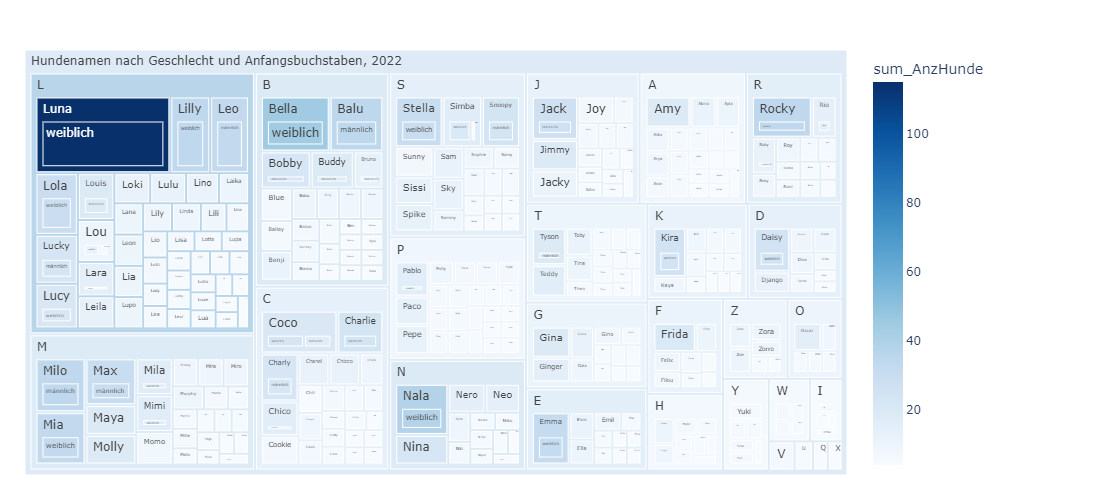

In [59]:
myTitle = "Hundenamen nach Geschlecht und Anfangsbuchstaben, 2022"

fig = px.treemap(myTreemapAgg.query('sum_AnzHunde > 3').reset_index(), path=[px.Constant(myTitle), 'FirstLetter', 'HundenameText', 'SexHundLang']
                 , values='sum_AnzHunde'
                 , color='sum_AnzHunde'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='Blues'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=500
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [60]:
myTreemapAgg = data2betested.loc[year_today]  \
    .groupby(['HundenameText', 'SexHundLang', 'FirstTwoLetters']) \
    .agg(sum_AnzHunde=('AnzHunde', 'sum')) \
    .sort_values('sum_AnzHunde', ascending=False) 

myTreemapAgg.reset_index().head(3)

HundenameText SexHundLang FirstTwoLetters  sum_AnzHunde
0          Luna    weiblich              Lu           115
1         Bella    weiblich              Be            45
2          Nala    weiblich              Na            38

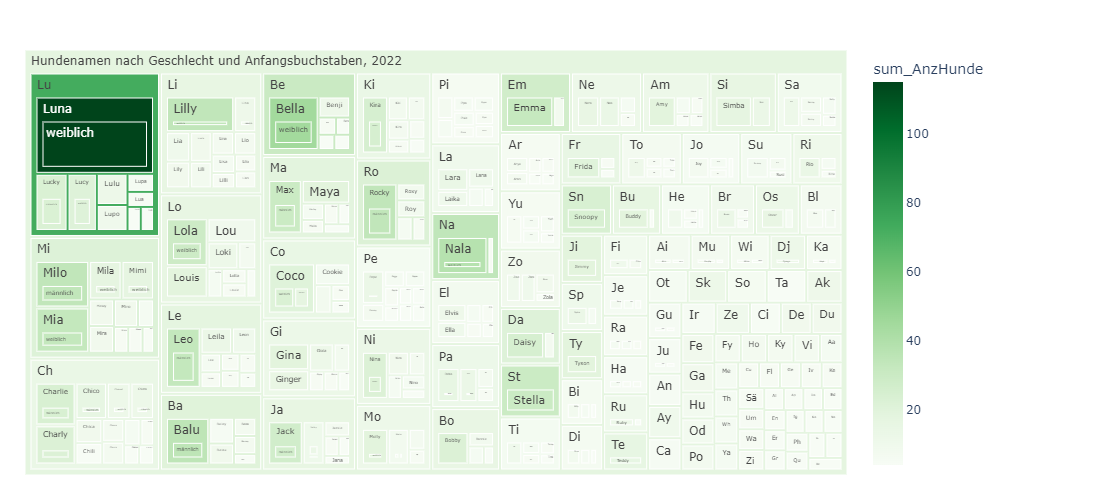

In [61]:
myTitle = "Hundenamen nach Geschlecht und Anfangsbuchstaben, 2022"

fig = px.treemap(myTreemapAgg.query('sum_AnzHunde > 3').reset_index(), path=[px.Constant(myTitle), 'FirstTwoLetters', 'HundenameText', 'SexHundLang']
                 , values='sum_AnzHunde'
                 , color='sum_AnzHunde'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='Greens'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=500
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [170]:
myTreemapAgg = data2betested.loc["2015":year_today]  \
    .groupby(['HundenameText', 'SexHundLang']) \
    .agg(sum_AnzHunde=('AnzHunde', 'sum')) \
    .sort_values('sum_AnzHunde', ascending=False) 

myTreemapAgg.reset_index().head(3)
#, 'FirstTwoLetters'

HundenameText SexHundLang  sum_AnzHunde
0          Luna    weiblich           745
1         Rocky    männlich           291
2           Leo    männlich           254

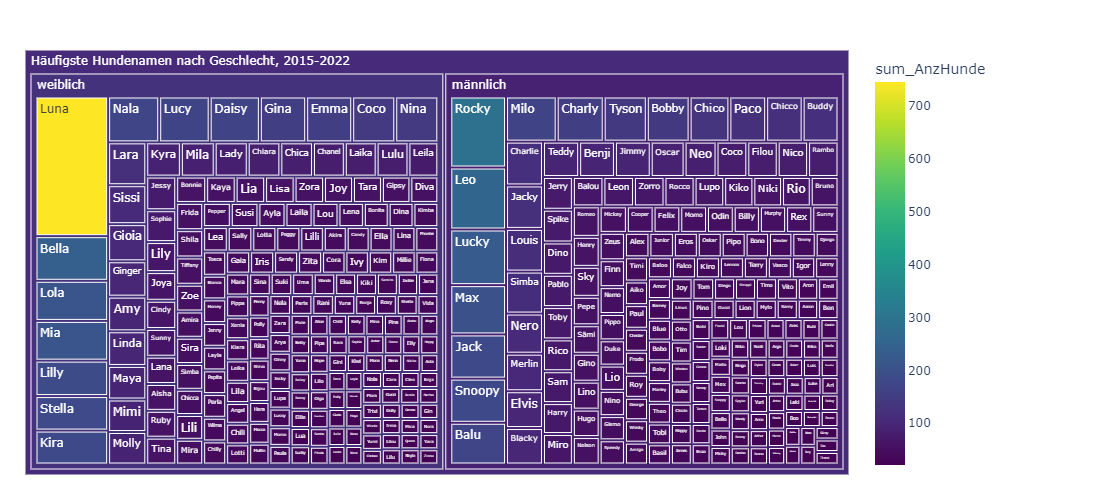

In [171]:
myTitle = "Häufigste Hundenamen nach Geschlecht, 2015-"+year_today

fig = px.treemap(myTreemapAgg.query('sum_AnzHunde > 20').reset_index(), path=[px.Constant(myTitle), 'SexHundLang','HundenameText' ]
                 , values='sum_AnzHunde'
                 , color='sum_AnzHunde'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','weiblich':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'männlich':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='viridis'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=500
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link]()**